In [1]:
# 中国平安在21年有大跌，所以前面的数据会影响预测精度

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tushare as ts

tf.random.set_seed(8)

pro = ts.pro_api()
pro = ts.pro_api('107616fccaaf92567ab2299cf5b6ce3b5044922d11045bebe6664811')

df = ts.get_k_data('601318', start='2021-08-01', end='2021-12-31')
# df = pd.concat([data.DataReader(t, source, start, end) for t in tickers]).reset_index()
dates = df["date"]
df


本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


/opt/anaconda3/lib/python3.9/site-packages/tushare/stock/trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


,date,open,close,high,low,volume,code
140,2021-08-02,51.140,51.650,52.620,50.130,971611.0,601318
141,2021-08-03,51.520,51.880,52.050,51.220,658203.0,601318
142,2021-08-04,51.940,51.240,51.940,50.970,646660.0,601318
143,2021-08-05,51.150,51.840,53.140,50.990,843221.0,601318
144,2021-08-06,51.090,51.310,51.480,50.690,502411.0,601318
...,...,...,...,...,...,...,...
238,2021-12-27,48.474,48.494,48.714,48.384,274701.0,601318
239,2021-12-28,48.814,49.384,49.644,48.614,617359.0,601318
240,2021-12-29,49.614,49.324,49.674,49.034,376469.0,601318
241,2021-12-30,49.414,48.924,49.504,48.924,427880.0,601318


In [2]:
cols = list(df)[1:3]
df_train = df[cols].astype(float)
df_train
# df_plt = df_train.tail(5000)
# df_plt.plot.line()

,open,close
140,51.140,51.650
141,51.520,51.880
142,51.940,51.240
143,51.150,51.840
144,51.090,51.310
...,...,...
238,48.474,48.494
239,48.814,49.384
240,49.614,49.324
241,49.414,48.924


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(df_train)
scaled

array([[0.7290401 , 0.75423729],
       [0.77521264, 0.78208232],
       [0.82624544, 0.70460048],
       [0.73025516, 0.77723971],
       [0.72296476, 0.71307506],
       [0.69258809, 0.88861985],
       [0.89307412, 0.96246973],
       [1.        , 0.97094431],
       [1.        , 0.84261501],
       [0.82381531, 0.7905569 ],
       [0.78979344, 0.86561743],
       [0.87363305, 0.77845036],
       [0.79222357, 1.        ],
       [0.98298906, 0.71791768],
       [0.68165249, 0.63317191],
       [0.66950182, 0.59564165],
       [0.58323208, 0.48668281],
       [0.53705954, 0.46004843],
       [0.48602673, 0.30508475],
       [0.43134872, 0.51089588],
       [0.54678007, 0.35472155],
       [0.32806804, 0.2566586 ],
       [0.27703524, 0.44915254],
       [0.42648846, 0.45641646],
       [0.49331713, 0.47578692],
       [0.509113  , 0.46004843],
       [0.50060753, 0.55205811],
       [0.54678007, 0.50484262],
       [0.47387606, 0.46489104],
       [0.46780073, 0.47578692],
       [0.

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(scaled, test_size=0.25, random_state=0)
print(train.shape)
print(test.shape)

(77, 2)
(26, 2)


In [5]:
days_future = 7
days_past = 14

train_X = []
train_y = []
test_X = []
test_y = []

for i in range(days_past, len(train) - days_future + 1):
    train_X.append(train[i - days_past:i, 0:train.shape[1]])
    train_y.append(train[i + days_future - 1:i + days_future, 0])
    
for i in range(days_past, len(test) - days_future + 1):
    test_X.append(test[i - days_past:i, 0:train.shape[1]])
    test_y.append(test[i + days_future - 1:i + days_future, 0])
    
train_X, train_y, test_X, test_y = np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)
    
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(57, 14, 2)
(57, 1)
(6, 14, 2)
(6, 1)


In [6]:
# To solve the problem: To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
# Don't know why, just copy this solution of CSDN
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [7]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Layer
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, activation="relu", input_shape = (train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units = 64, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False, dropout=0.5))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = "mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17152     
                                                                 
 lstm_1 (LSTM)               (None, 14, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 62,625
Trainable params: 62,625
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=1)

Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 0.2247 - val_loss: 0.1692
Epoch 2/10
1/1 [==============================] - 0s 91ms/step - loss: 0.1821 - val_loss: 0.1272
Epoch 3/10
1/1 [==============================] - 0s 109ms/step - loss: 0.1446 - val_loss: 0.0894
Epoch 4/10
1/1 [==============================] - 0s 116ms/step - loss: 0.1119 - val_loss: 0.0566
Epoch 5/10
1/1 [==============================] - 0s 117ms/step - loss: 0.0844 - val_loss: 0.0313
Epoch 6/10
1/1 [==============================] - 0s 86ms/step - loss: 0.0560 - val_loss: 0.0179
Epoch 7/10
1/1 [==============================] - 0s 79ms/step - loss: 0.0453 - val_loss: 0.0217
Epoch 8/10
1/1 [==============================] - 0s 94ms/step - loss: 0.0447 - val_loss: 0.0397
Epoch 9/10
1/1 [==============================] - 0s 89ms/step - loss: 0.0569 - val_loss: 0.0517
Epoch 10/10
1/1 [==============================] - 0s 107ms/step - loss: 0.0665 - val_loss: 0.0498


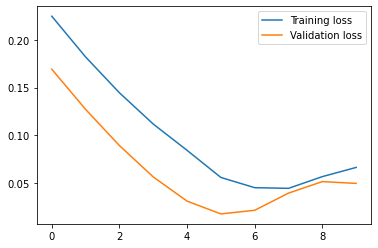

In [9]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [10]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
future = days_future + days_past

# days_past?
prediction_dates = pd.date_range(list(dates)[-future], periods=future, freq=us_bd).tolist()

prediction = model.predict(train_X[-future:])

1/1 [==============================] - 2s 2s/step


In [11]:
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_forecast = scaler.inverse_transform(prediction_copies)[:,0]

In [12]:
forecast_dates = []
for time_i in prediction_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'open':y_forecast})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

In [13]:
original = df[['date', 'open']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-8-1']

/var/folders/5_/bb05t_s57j12tjmc9s6_yg_r0000gn/T/ipykernel_48843/740320029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='open'>

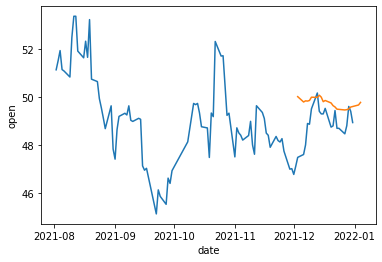

In [14]:
import seaborn as sns

sns.lineplot(original['date'], original['open'])
sns.lineplot(df_forecast['date'], df_forecast['open'])

In [15]:
result = pd.concat([df,df_forecast], axis=0, join="outer")
result.to_csv("601318_ZGPA.csv")

In [15]:
df.to_csv("601318_ZGPA.csv")